**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1pMqzLFl-moKOQVb113-OB8W4pp7wLSQg?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1lxksinATGNYlSFbs4ly3jauCDd6voGwF?usp=sharing)
2. Практический ноутбук 2

# Задача - симуляция посадки ракеты

Один из вариантов применения генетического алгоритма  - управление посадкой ракеты из библиотеки OpenAI.

Для начала необходимо установить окружение.

## Настройка окружения Colab

Движок box2d, на котором будет происходить симуляция посадки корабля рассчитан на работу, в первую очередь, в консоли, поэтому необходимо предварительно настроить среду

Загрузка требует около `2 минут`

Будем обращаться к линукс-ядру напрямую с помощью команд на "!"

Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)

Код, представленный в документации разработчика

In [ ]:
# cmake - сборка - аналог GNU Make, но с другим синтаксисом,
# libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!apt install swig cmake libopenmpi-dev zlib1g-dev

# устанавливаем непосредственно сам stable baseline и движок box2d
!pip install stable-baselines==2.5.1 box2d-py box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (912 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 12088

если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим

In [ ]:
# установка пакета для рендера видео
!pip install gym pyvirtualdisplay > /dev/null 2>&1

# установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба
!pip install xvfbwrapper

# обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!apt-get update

# установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!sudo apt-get install xvfb

# пакет для вывода процессов, происходящих на сервере
!apt-get install xdpyinfo

  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5009 sha256=ac81d9a576ebf69586098ad1fc5f2382b8e2f5f52948eb305b778712ed6e2868
  Stored in directory: /root/.cache/pip/wheels/cb/10/7d/2b7fdffccf837f7d5425931575fbee9caebe2c190931f9058b
Successfully built xvfbwrapper
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,030 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubu

## Импорт библиотек



In [ ]:
# здесь лежат все модели
import gym

# загрузим библиотеку для изменения параметра вывода ошибок
from gym import logger as gymlogger

# для правильного отображения ошибок
gymlogger.set_level(40)

# библиотека для обертки видео из хранилища в ячейку
from gym.wrappers import RecordVideo

# библиотека массивов numpy
import numpy as np

# библиотека для генерации случайных значений
import random

# библиотека для визуализации процессов
import matplotlib

# библиотека для построения графика
import matplotlib.pyplot as plt

%matplotlib inline

# расширение для использования Unix обозначений при задании пути к файлу
import glob

# библиотека для работы с потоковыми данными
import io

# расширение для преобразования в формат base64
# (универсальный формат хранения сырых изображений в виде набора электрических сигналов)
import base64

# библиотека для кодирования в код HTML
from IPython.display import HTML

# библиотека для расчета времени обучения
import time

# для работы с "сырым" форматом (набор сигналов, а не пиксели)
from IPython import display as ipythondisplay

# для создания окна дисплея
from pyvirtualdisplay import Display

Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Создаем функцию `show_video()`которая будет выводить нам в окно сформированный из кадров игры фильм и `Monitor()` которая будет регистрировать кадры игры

In [ ]:
def show_video():
  '''
  Функция, позволяющая записывать видео того,
  что происходит в окружении и отображать это в колаб

  '''
  # для поиска JPG файлов используем модуль glob.
  mp4list = glob.glob('video/*.mp4')

  if len(mp4list) > 0: # если лист не нулевой
    mp4 = mp4list[0] # получаем данные
    video = io.open(mp4, 'r+b').read() # открываем и читаем данные
    encoded = base64.b64encode(video)
    # формируем область вывода видео
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: # если лист пуст выводим тех.сообщение
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Симмуляция LunarLander-v2
https://gym.openai.com/envs/LunarLander-v2/


Задача данной симуляции заключается в посадке корабля на посадочную площадку.

Оценивается то, *куда* вы его посадите и *как*.

Для управления кораблем мы используем три двигателя:
- центральный,
- с левой ориентацией
- c правой ориентацией.

В итоге, на каждое из наших действий - **action** - среда выдает наблюдение - **observation**.

**Observation** - вектор размерности (8,):


> где первые шесть цифр - отклик самого физического движка:
- x-координата,
- y-координата,
- x-скорость,
- y-скорость,
- угол ракеты,
- угловая скорость,
- факт приземления на левую ногу,
- факт приземления на правую ногу),


> а последние две цифры - координаты приземления:
- пока ракета не приземлилась, последние два числа будут (0,0).
- если приземлилась на посадочной площадке, то (1,1).
- если риземлилась с какой-то из сторон, то (1,0) или (0,1) соответственно.

Важно то, *как* мы приземляемся!

За это отвечает награда - **reward**.
Баллы могут складываться и вычитаться в зависимости от действия. При этом топливо бесконечно и эпизод заканчивается в момент приземления (либо ракета падает, либо мягко приземляется). Допускается посадка вне посадочной площадки.
- Награда за переход от верхней части экрана к посадочной площадке и нулевой скорости составляет около 100..140 баллов.
- Если включен основной двигатель, то за каждый кадр (одно действие) -0,3 балла.
- Если ракета отходит от посадочной площадки, то присвоенная ранее награда за вычитается.
- За каждый контакт ноги с поверхностью +10 баллов.
- За падение (резкое приземление) -100 баллов,
- за мягкое приземление +100 баллов.
В сумме решеная задача (за переход от верхней части экрана к посадочной площадке + мягкое приземление) дает 200..250 баллов.

**Резюме**: на вход среды подаем одно из действий:

* 0 - ничего не делать
* 1 - запустить двигатель с левой ориентацией
* 2 - запустить двигатель по центру
* 3 - запустить двигатель с правой ориентацией

на выходе получаем вектор **observation** и **reward** за текущее действие.
Эпизод будет идти до момента приземления.

**Цель**: максимизировать награду

Пример ранее записанной эффективной посадки


![Lunar Lander](https://cdn-images-1.medium.com/max/960/1*f4VZPKOI0PYNWiwt0la0Rg.gif)




Давайте разберем, что выше написано.
- `Observation` - вектор размерности `(8,)`. На каждом шаге (нашем действии) программа выдает нам полную информацию об объекте в виде вектора `Observation`для принятия нами следующего действия `action`.

- `action` - это то, что мы на шаге делаем:

    0 - ничего не делать
    
    1 - запустить двигатель с левой ориентацией

    2 - запустить двигатель по центру

    3 - запустить двигатель с правой ориентацией

    Мы делаем что-то одно, то есть это число


### Запускаем среду

Для этого в модуль `gym` методом `make` подаем название нашей игры как список

In [ ]:
env = gym.make('LunarLander-v2')
# оборачиваем наше окружения для записи видео
env = wrap_env(env)

Вначале будем тренироваться на одном варианте рельефа местности. Для этого метом `.seed()` выбираем только один вариант, например `0` нулевой и далее создаем местность через `env.render()` и сбрасываем значение вектора `observation` (если были) через`env.reset()`

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
env.render() # Рендер окружения

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

Посмотрим, что выдаст нам программа при подаче в метод `step()` какое-то случайное значение от 0 до 3

In [ ]:
action = random.choice([0,1,2,3]) # случайно выбираем действие
print('action', action)
# подаем случайное действие
information = env.step(action)
# выводим ответ модкля
for inf in information:
    print(inf)

action 3
[ 0.01149282  1.3865795   0.5872511  -0.55358    -0.01509254 -0.16976053
  0.          0.        ]
-2.037431540065454
False
{}


Мы видим:
-  в первом элементе список - это и есть вектор состояния, который и есть `observation`
- во втором элементе нам выдается награда `reward` за действие
- в третеьм элементе `done` выдается ответ на земле корабль `True` или нет `False`.
- четвертый элемент не задейтвован в этой игре

Теперь используя для контроля значение в ячейке `done` через проверку `done == False`, мы можем запустить цикл оператором `while`, сказав, что пока это верно, то крутить цикл, а как только `done == False`неверно,  то выйти из цикла.

мы будем на каждом шаге подавать просто рандомное число из метода `random.choice([0,1,2,3])`

Так же в конце циклв необходимо остановить игру методом `env.close()` и показать записанное видео игры функцией `show_video()`

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
#env.render() # Рендер окружения
observation = env.reset() # обнуляем вектор наблюдения

done = False
while done == False:
    env.render() # Рендер окружения
    action = random.choice([0,1,2,3])
    observation,reward,done,_ = env.step(action)

env.close()
show_video()

### Матричное умножениее

Нам удалось запустить и отобразить игру, подавая случайные варианты действия корабля. Но мы никак не использывали ответы среды `observation` о состоянии коробля.

`observation` - это вектор с размерностью `(8,)`

Общая идея генетического агоритма для данной игры исходит из области нейронных сетей.

Нейронные сети - это тензоры, что похоже на матрицу.

Мы можем составить список возможных действий длиной 4 и выбирать номер индекса от 0 до 3, что соответсвует вариантам наших действий.

Посмотрим на схему матричного умножения ниже, котороя ляжет в основу алгоритма

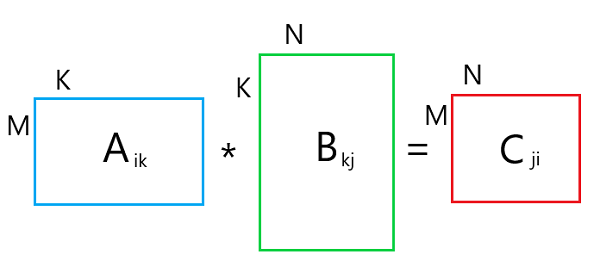

- `A` - это вектор `observation` размерностью `(8,)`, который мы получаем на каждом шаге от программы

- `C` - это некий `result` размерностью `(4,0)`. в каждой ячейке которого у нас должно получаться число от 0 до 1 `вероятность действия` и далее, применяя к нему метод `argmax()`, мы выбираем номер элемента с большей вероятностью, это и будет наше действие `action` на текущем шаге игры. Это похоже на классификацию в нейронках, когда через функцию активации `softmax` выбирается наиболее весомый ответ.

Как же нам перейти от `A` к `C`?

Идея лежит в самой картине матричного произведения - это должна быть матрица размерность `(8,4)`

Это и будут наши боты популяцию которых мы можем сгенерировать,произвести умножение каждого, получить через `argmax()` ответ для каждого и проверить ответ среды на каждый бот. То есть мы будем производить игру с каждым ботом от и до. Количество игр равно размеру популяции.

Но как нам отбирать лучших ботов для посика лучшего, который будет хорошо сажать ракету на любой ответ среды? То есть это будет такая матрица, что при умножение на нее ответа среды, полученные ответы на кадом этаме игры посадят корабль аккуратно.

В ответе от модуля `env.step(action)` на `action` есть еще значение `rewards` то есть вознаграждение (см. выше в условиях). Значит мы будем отбирать ботов которые за игру получат максимальную оценку и будем из лучших уже отбирать родителей для генерации нового поколения ботов и возобновления тестов по поиску лучшего бота.

Создаем методом `np.random.random()` популяцию из ботов, являющихся массивом размером (8,4).

In [ ]:
numBots = 100 # количество ботов популяция
popul = [] # здесь будет лежать популяция

# проходимся по длине будущей популяции
for i in range(numBots):
  # создаем очередного случайного бота в виде матрицы (8,4)
  bot = np.random.random((8,4))
  # добавляем бота в популяцию
  popul.append(bot)

# возьмем случайный бот из популяции
rand_bot = random.choice(popul)
print(rand_bot) # выведем его

[[0.54690368 0.48724939 0.15844155 0.63380487]
 [0.4778681  0.83545836 0.54502611 0.39279653]
 [0.07935284 0.10695021 0.42626122 0.42379296]
 [0.40278608 0.31648879 0.35789857 0.9698935 ]
 [0.99654072 0.65149612 0.96173748 0.52557764]
 [0.61942008 0.65066171 0.19245666 0.10731628]
 [0.42012385 0.49812529 0.24123398 0.68444426]
 [0.44047726 0.05685094 0.30252781 0.77485695]]


выведем идею через матричное умножение `np.dot()` вектора `observation` и матрицы бота `rand_bot`, применив `np.argmax()` к результату `result` их умножение

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
print('observation')
print(observation)
print('shape', np.array(observation).shape)
print()
# возьмем случайный бот из популяции
rand_bot = random.choice(popul)
print('rand_bot') # выведем его
print(rand_bot) # выведем его
print('shape', np.array(rand_bot).shape)
print()
result = np.dot(observation, rand_bot)
print('result', result)
print('shape', np.array(result).shape)
print()
action = np.argmax(result)
print('action', action)

observation
[ 0.00570612  1.3990337   0.5779653  -0.5282997  -0.0066053  -0.13091765
  0.          0.        ]
shape (8,)

rand_bot
[[0.97381514 0.65598242 0.12962976 0.42989092]
 [0.2515014  0.1448742  0.50988236 0.53135162]
 [0.93794567 0.28591386 0.63835687 0.8324596 ]
 [0.59820258 0.88421789 0.35209253 0.62250726]
 [0.12043735 0.68325788 0.5059399  0.44406291]
 [0.87917675 0.71938936 0.82516496 0.24362257]
 [0.38054865 0.28309574 0.11131291 0.79606728]
 [0.82144824 0.77874859 0.63980066 0.96860384]]
shape (8, 4)

result [ 0.46759018 -0.19415063  0.78564947  0.86326654]
shape (4,)

action 3


Повторя код вновь мы будем брать случайно бот из нашей популяции и видеть каое он генерирует действие `action`.

Подав идею с ботом в ранее опробованный код игры, мы уже сыгаем с помощь из бота

Проверим, что умеет случайный "необученный" бот

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
#i=0
# обнуляем переменную от других эксперементов
action = 0
# возьмем случайный бот из популяции
rand_bot = random.choice(popul)

done = False # стартовое значение
while done == False: # пока верно, цикл идет

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    # остлеживаем все параметры для подсчета функции значения
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation, rand_bot)
    # находим действие для следующего шага игры
    action = np.argmax(result)

env.close()
show_video()

Запуская ячейку вновь, мы будем выбирать случайно бот из популяции и получать совсем разные результаты, даже забавные

## Генетические алгоритмы

Теперь у нас есть вес необходимое для адаптации кода генетического алгоритма из прошлых задач к задаче поиска бота для посадки


### Функции генетики без изменений

Активируем уже изученные  в практическом ноутбуке 1 функции `getSurvPopul()`, `getParents()`, `crossPointFrom2Parents()`

In [ ]:
def getSurvPopul(
        popul,
        val,
        nsurv,
        reverse
        ):
    '''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
    '''
    newpopul = [] # Двумерный массив для новой популяции
    # Сортируем зачения в val в зависимости от параметра reverse
    sval = sorted(val, reverse=reverse)

    # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
    for i in range(nsurv):
        # Получаем индекс i-того элемента sval в исходном массиве val
        index = val.index(sval[i])
        # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом
        newpopul.append(popul[index])
    # Возвращаем новую популяцию (из nsurv элементов) и сортированный список
    return newpopul, sval


def getParents(
        curr_popul,
        nsurv
        ):

    '''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
    '''
    # Получаем дважды случайный индекс родителе в диапазоне от 0 до nsurv - 1
    indexp1 = random.randint(0, nsurv - 1)
    indexp2 = random.randint(0, nsurv - 1)

    botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
    botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2
    return botp1, botp2 # Возвращаем обоих полученных ботов


def crossPointFrom2Parents(
        botp1,
        botp2,
        idx
        ):
    '''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - idx - номер компонента бота
    '''
    pindex = random.random() # Получаем случайное число в диапазоне от 0 до 1

    # Если pindex меньше 0.5, то берем ген первого бота, иначе от второго
    if pindex < 0.5:
        x = botp1[idx]
    else:
        x = botp2[idx]
    return x # Возвращаем значние гена

### Функция вознаграждения

В данной задаче в отличии от прошлых, мы будем уже искать не минимум, а максимум. Мы будем собирать значения от игры каждого бота.

Мы организуем цикл по популяции через `for in` и для каждого бота запустим код игры опробованый выше.

Но теперь мы еще будем суммировать на каждом шаге игры бота получаемое им вознаграждение и далее собирать итоговое вознаграждение в лист вознаграждений всех ботов `reward_list`.

Его в итоге и будем пулучать как результат работы функции

In [ ]:
def countValue(
    popul
    ):

  '''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
  '''
  action=0  # генерируем первое  действие случайным из пространства действий
            # 0 - ничего не делать
            # 1 - запустить двигатель с левой ориентацией
            # 2 - запустить двигатель по центру
            # 3 - запустить двигатель с правой ориентацией

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  # проходимся по каждому боту в популяции
  for bot in popul:
    # При инициализации среда генерируется случайным образом каждый раз новая,
    env.seed(0)
    # будем использовать только одну конкретную среду, указвая 0
    env.reset() # И обновлять окружение
    tmp=0
    done = False # стартовое значение
    while done == False: # пока верно, цикл идет
      # остлеживаем все параметры для подсчета функции значения
      observation,reward,done,_ = env.step(action)
      tmp+=reward # прибавляем вознаграждение от действия по боту
      # матрично перемножаем бота и вектор наблюдения для следующего движения
      result = np.dot(observation,bot)
      action = np.argmax(result) # максимальный аргумент - наше движение
    # Собираем в лист итоговое вознаграждение каждого бота
    reward_list.append(tmp)

  return reward_list

### Эволюция ботов на одной среде


Теперь мы возьмем код генетического кода с вагонами, где мы применяли случайно применяли мутацию к гену и еще меняли саму мутацию по ходу поиска.

Нам нужно  изменить в коде функцию проверки, это теперь функция `countValue()` и указать в функции `getSurvPopul()` параметр `reverse` как `1`, так как теперь мы будем отбирать именно с большим значением, как бы по точности, чем выше, тем лучше!

Нужно набраться терпения, так как поначалу код может долго не выдавать результат, так некоторые боты могут выдавать решения с долго парящим кораблем, то есть игра будет долго идти, так как игра оканчивается когда корабль упал или приземлился на обе ноги. Постепенно время стабилизируется по популяции.

0 15.942070722579956   [48.62882901257262, 28.925236872841737, -63.839242836917876]
1 3.275134563446045   [39.45850290550419, 22.639033573165918, -14.232650512886735]
2 0.28339576721191406   [16.9259508891447, -8.483089363660369, -39.56781460627951]
3 4.855891704559326   [36.30573003586011, 31.336288160465642, 7.1046231087183]
4 0.5308616161346436   [31.336288160465642, -35.20691371969137, -39.56781460627951]
5 0.4689140319824219   [-7.058977235627481, -15.82746572434192, -19.22087352010837]
6 0.485823392868042   [25.806700813858583, -12.90308981138908, -39.278505150224944]
7 3.910820245742798   [40.84599029868738, 24.811030863310904, 24.811030863310904]
8 0.397676944732666   [66.01417724662258, 54.083635143801416, 53.4406422627919]
9 0.41890382766723633   [53.196659353002616, 16.829660442341847, -7.686343781183297]
Смена мутации на 0.3

10 0.4185197353363037   [-0.5054168856424042, -1.7747489527614846, -10.627500262155749]
11 4.142780065536499   [61.80109560151507, 38.12728262939393, 

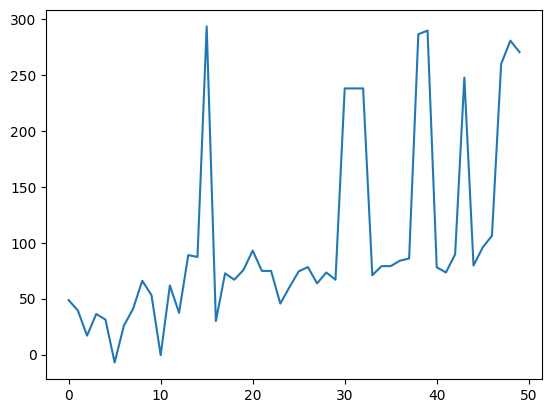

In [ ]:
total=[] # Для построения графика
n = 40 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 50 # количество эпох
mut = 0.4 # коэфициент мутаций
eph_change_mut = [10, 20, 30, 40, 45] # эпохи смены коэфициента мутации
new_mut = [0.3, 0.27, 0.25, 0.21, 0.19] # новый коэфициент мутаци

curr_time = time.time() # запоминаем время начала

# создали список списков всех значений по эпохам
for it in range(epohs):
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
      idx = eph_change_mut.index(it) # получаем индекс  по эпохе
      mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
      print('Смена мутации на', mut)
      print()
    val = countValue(popul) # считаем успех каждого из ботов
    # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
    newpopul, sval = getSurvPopul(popul, val, nsurv, 1)
    # Выводим время на операцию, среднее значение и 20 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:3])
    # заносим самого лучшего бота в список для построения графика эволюции
    total.append(sval[0])
    curr_time = time.time() # Обновляем текущее время

    # проходимся по новой популяции
    for k in range(nnew):
        # вытаскиваем новых родителей
        botp1, botp2 = getParents(newpopul, nsurv)
        newbot = [] # здесь будет новый бот

        # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
        for j in range(len(botp1)):
            x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
            for t in range(4):
                if random.random()<mut:
                  x[t] += random.random()*1e-1
            newbot.append(x) # закидываем элемент в бота
        newpopul.append(newbot) # добавляем бота
    popul = newpopul # вывести список на эпоху
    # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
    popul = np.array(popul)
plt.plot(total)
print(np.mean(total))

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения

action = 0
done = False # стартовое значение
while done == False: # пока верно, цикл идет
    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    # остлеживаем все параметры для подсчета функции значения
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,newpopul[1])
    action = np.argmax(result)

env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# итоговое вознаграждение
reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-100

Посмотрим что случиться если убрать постоянство рельефа и попробовать посадить тем же ботом корабль на случайно сгенерированный рельеф.

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
# env.seed(0)
observation = env.reset() # обнуляем вектор наблюдения

action = 0
done = False # стартовое значение
while done == False: # пока верно, цикл идет
    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[0])
    action = np.argmax(result)

env.close()
show_video()

In [ ]:
reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-100

Похоже, что в новой среде наш бот бесполезен.

### Эволюция ботов на случайно сгенерированных средах


Мы можем усложнить задачу генетическому алгоритму в поиске, убрав фиксацию среды в `env.seed(0)`, закоментировав строку символом `#`

Обновим наш функцию подсчета вознаграждения.

In [ ]:
def countValue(
    popul
    ):

  '''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
  '''
  action=0  # генерируем первое  действие случайным из пространства действий
            # 0 - ничего не делать
            # 1 - запустить двигатель с левой ориентацией
            # 2 - запустить двигатель по центру
            # 3 - запустить двигатель с правой ориентацией

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  # проходимся по каждому боту в популяции
  for bot in popul:
    # При инициализации среда генерируется случайным образом каждый раз новая,
    #env.seed(0)
    # будем использовать только одну конкретную среду, указвая 0
    env.reset() # И обновлять окружение

    tmp=0
    done = False # стартовое значение
    while done == False: # пока верно, цикл идет
      # остлеживаем все параметры для подсчета функции значения
      observation,reward,done,_ = env.step(action)
      tmp+=reward # прибавляем вознаграждение от действия по боту
      # матрично перемножаем бота и вектор наблюдения для следующего движения
      result = np.dot(observation,bot)
      action = np.argmax(result) # максимальный аргумент - наше движение
    # Собираем в лист итоговое вознаграждение каждого бота
    reward_list.append(tmp)

  return reward_list

Запустим новое обучение

0 6.207634210586548   [21.564645824060577, -2.700669633295192, -6.7109042538291135]
1 4.052827835083008   [40.58955197948384, 26.766830117375903, 23.29975678155796]
2 2.1539530754089355   [146.2448838537271, 7.270587771954794, 4.666689370322331]
3 3.248418092727661   [240.5953087114773, 178.5595517471818, 24.75366547404488]
4 2.3535218238830566   [155.44227453407083, 46.28935971334144, 32.136297210339904]
5 5.422412633895874   [170.7581337120123, 19.684324107399718, 19.29671994086806]
6 0.8086154460906982   [27.015142333233527, 24.06297698977245, 13.272787816417292]
7 3.1060450077056885   [189.47434149615296, 42.4166841740481, 39.0088787417732]
8 4.813689470291138   [28.812899614527282, 27.931044848182346, 8.618996226276394]
9 2.062883138656616   [125.70611835677407, 28.009810481831835, 18.61681597088068]
Смена мутации на 0.3

10 3.2505950927734375   [21.286196262980155, 9.312917030102298, 5.395503356901912]
11 0.7852210998535156   [29.997612717426335, 17.660277715634308, -3.3694423830

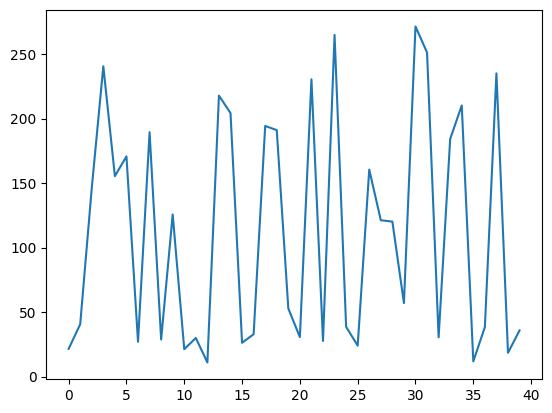

In [ ]:
total=[] # Для построения графика
n = 40 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 40 # количество эпох
mut = 0.4 # коэфициент мутаций
eph_change_mut = [10, 20, 30, 35] # эпохи смены коэфициента мутации
new_mut = [0.3, 0.27, 0.25, 0.19] # новый коэфициент мутаци


curr_time = time.time() # запоминаем время начала

# создали список списков всех значений по эпохам
for it in range(epohs):
    # проверяем текущую эпоху it на принадлежность графику смены мутации
    if it in eph_change_mut:
      idx = eph_change_mut.index(it) # получаем индекс  по эпохе
      mut = new_mut[idx] # проверяем текущую эпохуобновляем мутацию
      print('Смена мутации на', mut)
      print()
    val = countValue(popul) # считаем успех каждого из ботов
    # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
    newpopul, sval = getSurvPopul(popul, val, nsurv, 1)
    # Выводим время на операцию, среднее значение и 20 лучших ботов
    print(it, time.time() - curr_time, " ", sval[0:3])
    # заносим самого лучшего бота в список для построения графика эволюции
    total.append(sval[0])
    curr_time = time.time() # Обновляем текущее время

    # проходимся по новой популяции
    for k in range(nnew):
        # вытаскиваем новых родителей
        botp1, botp2 = getParents(newpopul, nsurv)
        newbot = [] # здесь будет новый бот

        # боты-родители одинаковой длины, будем проходиться по каждому элементу родителя
        for j in range(len(botp1)):
            x = crossPointFrom2Parents(botp1, botp2,j) # скрещиваем
            for t in range(4):
                if random.random()<mut:
                  x[t] += random.random()*1e-1
            newbot.append(x) # закидываем элемент в бота
        newpopul.append(newbot) # добавляем бота
    popul = newpopul # вывести список на эпоху
    # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
    popul = np.array(popul)
plt.plot(total)
print(np.mean(total))

Проверим бота на 3х разных рельефах

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
# env.seed(0)
observation = env.reset() # обнуляем вектор наблюдения

action = 0
done = False # стартовое значение
while done == False: # пока верно, цикл идет
    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    # остлеживаем все параметры для подсчета функции значения
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,popul[0])
    action = np.argmax(result)

env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
# env.seed(0)
observation = env.reset() # обнуляем вектор наблюдения

action = 0
done = False # стартовое значение
while done == False: # пока верно, цикл идет
    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    # остлеживаем все параметры для подсчета функции значения
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,popul[0])
    action = np.argmax(result)

env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
# env.seed(0)
observation = env.reset() # обнуляем вектор наблюдения

action = 0
done = False # стартовое значение
while done == False: # пока верно, цикл идет
    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    # остлеживаем все параметры для подсчета функции значения
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,popul[0])
    action = np.argmax(result)

env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Мы получили вполне умелого бота!!

**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1pMqzLFl-moKOQVb113-OB8W4pp7wLSQg?usp=sharing)
2. [Практический ноутбук 1](https://colab.research.google.com/drive/1lxksinATGNYlSFbs4ly3jauCDd6voGwF?usp=sharing)
2. Практический ноутбук 2